# Build stratified dataset

__Objective:__ create a train/test splits from the Kumar dataset satisfying the following criteria
- stratification **by class** (class frequencies roughly the same between training and test data),
- stratification **by annotator** (the **same annotators** must appear both in the training and test data - otherwise we have the cold start problem for the annotator-specific models),
- no comment is replicated between training and test data (for different annotators) - otherwise there's clear data leakage,
- each annotator has **at least** some number samples in the training split (an absolute minimum number, to allow for the annotator-specific model to learn).

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../modules/')

from custom_logger import get_logger

logger = get_logger('build_stratified_dataset')

sns.set_theme()

%load_ext autoreload
%autoreload 2

## Load full dataset and extreme annotators data

In [2]:
binarization_threshold = 1

# Read toxicity data.
data_df = pd.read_csv('/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/kumar_processed_with_ID_and_full_perspective_clean.csv')[
    ['comment', 'text_id', 'worker_id', 'toxic_score']
]

# Binarize the toxicity score (label), if required.
if binarization_threshold is not None:
    logger.info(f'Binarizing labels with threshold: {binarization_threshold}')
    
    data_df['toxic_score'] = (data_df['toxic_score'] >= binarization_threshold).astype(int)

# Read extreme annotators data.
extreme_annotators = pd.read_csv('/data1/moscato/personalised-hate-boundaries-data/data/extreme_annotators.csv').drop(columns=['Unnamed: 0'])

extreme_annotators.loc[
    extreme_annotators['percent_higher'] > 50.,
    'extreme_annotator'
] = 'higher'

extreme_annotators.loc[
    extreme_annotators['percent_lower'] > 50.,
    'extreme_annotator'
] = 'lower'

# Merge toxicity and extreme annotator data.
data_df = pd.merge(
    left=data_df,
    right=extreme_annotators[['worker_id', 'extreme_annotator']],
    on='worker_id',
    how='left'
)

data_df['extreme_annotator'] = data_df['extreme_annotator'].fillna('no')

data_df

/tmp/ipykernel_169666/1231251914.py:4: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv('/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/kumar_processed_with_ID_and_full_perspective_clean.csv')[
2025-01-31 16:01:47,132 - build_stratified_dataset - INFO - Binarizing labels with threshold: 1


,comment,text_id,worker_id,toxic_score,extreme_annotator
0,Just a matter of time before pick up on this s...,0,24482c451b411b96d2c2880bafbab9884007e000d143c0...,0,no
1,Just a matter of time before pick up on this s...,0,dbc501198ada6725d8e8cc6f0101824f04d4b4b8935059...,0,no
2,Just a matter of time before pick up on this s...,0,29a3513367445e0fd3c53d61da1fcbebbf4efc6e0de0b9...,0,no
3,Just a matter of time before pick up on this s...,0,26523080557217fc3b42c882aecab5863966ccfbe31c3f...,0,no
4,Just a matter of time before pick up on this s...,0,aa351a28dee4f23fd6abcbb91f9d663440825c8d7455b7...,0,no
...,...,...,...,...,...
537627,"""Boo hoo, Tharizdun wants me to be his avatar!...",106034,fd2b94f93b67f7f8a0643ffd5c58e463ed807317ea8174...,1,no
537628,"""Boo hoo, Tharizdun wants me to be his avatar!...",106034,4e3ea78083d10f22c6d3b81d31caec4c6d1adf8486ad79...,1,no
537629,"""Boo hoo, Tharizdun wants me to be his avatar!...",106034,861e81f540c445ccdd16ab6d44e1f0ba45b497d5896583...,0,no
537630,"""Boo hoo, Tharizdun wants me to be his avatar!...",106034,bf743766bfd85b146bb4f1a8de00fad45fe9f6f78c18e4...,0,no


In [3]:
# Annotators that gave a toxicity score higher by more than 0.5 points
# w.r.t. to a text's average for more than 50% of their rated texts.
(extreme_annotators['percent_higher'] > 50.).sum()

np.int64(915)

In [4]:
# Annotators that gave a toxicity score lower by more than 0.5 points
# w.r.t. to a text's average for more than 50% of their rated texts.
(extreme_annotators['percent_lower'] > 50.).sum()

np.int64(96)

In [5]:
# Fraction of extreme annotators.
data_df.groupby('worker_id')['extreme_annotator'].first().value_counts() / data_df['worker_id'].unique().shape[0]

extreme_annotator
no        0.941469
higher    0.052973
lower     0.005558
Name: count, dtype: float64

## Analysis

Distribution of number of annotated comments per annotator.

In [6]:
annotations_counts = data_df.groupby('worker_id')['text_id'].count().reset_index().rename(columns={'text_id': 'n_annotations'})

annotations_counts

,worker_id,n_annotations
0,0000bbbabf603bb87e8e3e69ce50317be51eaca22c0e27...,20
1,00075582a32d67472e3af1cadd60dbfeb5be6303f480e4...,20
2,0009937cfd1525a046f4fda749936bd14bb92d14e094fb...,40
3,0009e9a4a0ed755d3e403d2b7d91e35db1cc04e817c199...,20
4,000aaa2fbb9fc466f2a0050b085478bc1e76288a611e36...,20
...,...,...
17268,fff3efa3c5522afcb76717c88d4db125c22e00d8e4ae08...,80
17269,fff54aeae0dbc01daebb50dd74d22001a78cb220600272...,20
17270,fff6550d46b4616c175d818cdb2c6677fd67046017cb52...,60
17271,fff6c9e818287b169f201f1f7f7f1358ee28ceb968ec68...,20


Text(0.5, 1.0, 'Distribution of number of annotations per annotator')

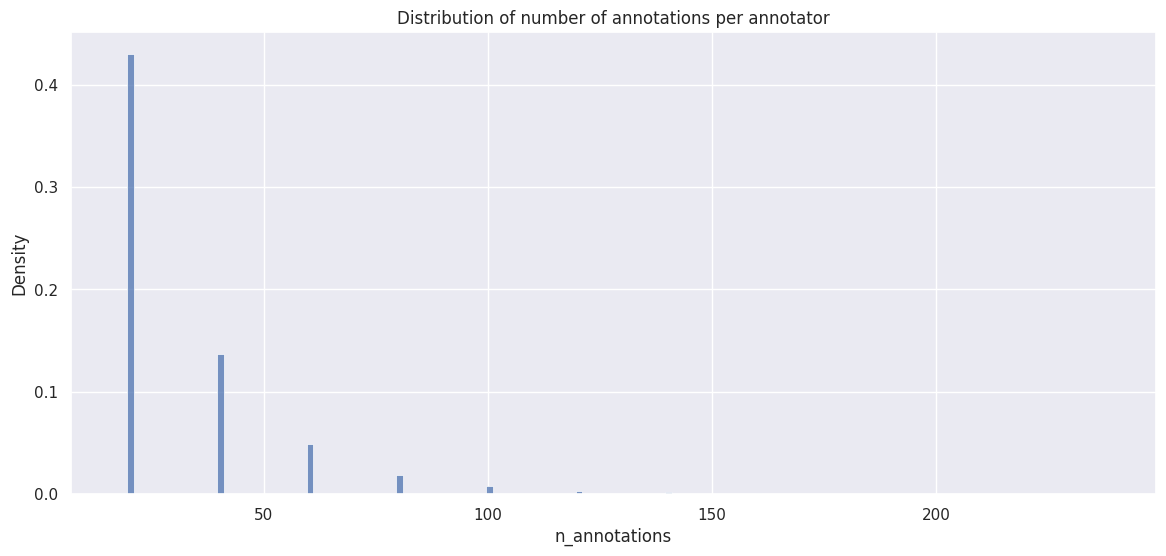

In [7]:
fig = plt.figure(figsize=(14, 6))

sns.histplot(
    x=annotations_counts['n_annotations'],
    stat='density'
)

plt.title('Distribution of number of annotations per annotator')

## Dataset construction

Steps:
1. Set a minimum number of training and test annotations an annotator must have: below these either there aren't enough samples to train an annotator-specific model or there aren't enough samples to evaluate such a model after training.

**From the data:** 66% of the annotators have 20 annotations, most of the rest have fewer.

In [8]:
(annotations_counts.groupby('n_annotations')['worker_id'].count().sort_index() / len(annotations_counts))

n_annotations
18     0.001158
20     0.661437
37     0.000058
38     0.000637
40     0.209865
57     0.000058
58     0.000868
60     0.074451
77     0.000174
78     0.000579
80     0.028252
98     0.000579
100    0.011521
117    0.000058
118    0.000116
120    0.005210
138    0.000232
140    0.002663
158    0.000116
160    0.001158
180    0.000579
200    0.000174
238    0.000058
Name: worker_id, dtype: float64

In [9]:
# Set the minimum number of training and test annotations we want
# for each annotator.
min_n_annotations_training, min_n_annotation_test = (12, 6)  # If they add up to 18 we don't discard any annotator.

logger.info(
    'Filtering for number of annotations'
    f' | Min n annotations training: {min_n_annotations_training}'
    f' | Min n annotations test: {min_n_annotation_test}'
)

# Filter out the annotators who don't have enough annotations.
selected_annotators = annotations_counts[
    annotations_counts['n_annotations'] >= min_n_annotations_training + min_n_annotation_test
]['worker_id'].tolist()

logger.info(
    f'N annotators (original): {len(annotations_counts)}'
    f' | N annotators (after filtering): {len(selected_annotators)}'
    f' | N dropped annotators: {len(selected_annotators) - len(annotations_counts)}'
)

# Filter the dataset to contain only the selected annotators.
original_dataset_size = len(data_df)

data_df = data_df[data_df['worker_id'].isin(selected_annotators)].reset_index(drop=True)

logger.info(
    f'Dataset size (original): {original_dataset_size}'
    f' | Dataset size (after annotator filtering): {len(data_df)}'
)

2025-01-31 16:01:47,864 - build_stratified_dataset - INFO - Filtering for number of annotations | Min n annotations training: 12 | Min n annotations test: 6
2025-01-31 16:01:47,867 - build_stratified_dataset - INFO - N annotators (original): 17273 | N annotators (after filtering): 17273 | N dropped annotators: 0
2025-01-31 16:01:47,949 - build_stratified_dataset - INFO - Dataset size (original): 537632 | Dataset size (after annotator filtering): 537632


In [10]:
data_df

,comment,text_id,worker_id,toxic_score,extreme_annotator
0,Just a matter of time before pick up on this s...,0,24482c451b411b96d2c2880bafbab9884007e000d143c0...,0,no
1,Just a matter of time before pick up on this s...,0,dbc501198ada6725d8e8cc6f0101824f04d4b4b8935059...,0,no
2,Just a matter of time before pick up on this s...,0,29a3513367445e0fd3c53d61da1fcbebbf4efc6e0de0b9...,0,no
3,Just a matter of time before pick up on this s...,0,26523080557217fc3b42c882aecab5863966ccfbe31c3f...,0,no
4,Just a matter of time before pick up on this s...,0,aa351a28dee4f23fd6abcbb91f9d663440825c8d7455b7...,0,no
...,...,...,...,...,...
537627,"""Boo hoo, Tharizdun wants me to be his avatar!...",106034,fd2b94f93b67f7f8a0643ffd5c58e463ed807317ea8174...,1,no
537628,"""Boo hoo, Tharizdun wants me to be his avatar!...",106034,4e3ea78083d10f22c6d3b81d31caec4c6d1adf8486ad79...,1,no
537629,"""Boo hoo, Tharizdun wants me to be his avatar!...",106034,861e81f540c445ccdd16ab6d44e1f0ba45b497d5896583...,0,no
537630,"""Boo hoo, Tharizdun wants me to be his avatar!...",106034,bf743766bfd85b146bb4f1a8de00fad45fe9f6f78c18e4...,0,no


Compute splits and evaluation metric for the obtained splits.

In [4]:
def create_splits_on_text_ids(data_df, train_test_split):
    """
    Split the train and test splits of the dataset by partitioning
    the text IDs according to the selected fraction and then propagating
    this to the samples themselves.
    """
    # Impose the train-test split on the text IDs.
    text_ids = data_df['text_id'].unique()
    
    text_ids_test = np.random.choice(
        text_ids,
        size=text_ids.shape[0],
        replace=False
    )[:int(0.2 * text_ids.shape[0])]
    
    text_ids_train = text_ids[~np.isin(text_ids, text_ids_test)]
    
    # Propagate the train-test split on the samples.
    data_df_train = data_df[data_df['text_id'].isin(text_ids_train)].reset_index(drop=True)
    data_df_test = data_df[data_df['text_id'].isin(text_ids_test)].reset_index(drop=True)

    return data_df_train, data_df_test


def evaluate_splits(data_df_train, data_df_test, min_n_annotations_training):
    """
    Computes metrics to evaluate the train-test split of the dataset:
      * `test_frac_text_ids`: fraction of text IDs in the test split over the total (should
                              be very close to the `train_test_split` parameter used to
                              create the splits - by construction).
      * `test_frac_samples`: fraction of samples in the test split over the total (should be
                             as close as possible to `train_test_split` again, but this should
                             be verified a posteriori).
      * `annotatos_in_both_splits_frac`: fraction of annotators that appear in both splits (should
                                         be as close as possible to 1.).
      * `class_frequences_splits`: class frequencies across splits (and difference between splits)
                                   (the difference between splits should be as close as possible to 0
                                   so the same imbalance is replicated across the splits in the same
                                   way).
    """
    # Compute the split fraction on the text IDs.
    test_frac_text_ids = data_df_test['text_id'].shape[0] / (data_df_train['text_id'].shape[0] + data_df_test['text_id'].shape[0])
    
    # Compute the split fraction on the samples.
    # Note: at this point we are sure that no piece of text appears both in the training
    #       and in the test dataset.
    test_frac_samples = len(data_df_test) / (len(data_df_test) + len(data_df_train))
    
    # Compute the fraction of annotators appearing both in the training and test split
    # (objective: 1.).
    annotators_in_both_splits = set(data_df_train['worker_id'].unique()) & set(data_df_test['worker_id'].unique())
    annotators_in_both_splits_frac = (
        len(annotators_in_both_splits) /
        len(set(data_df_train['worker_id'].unique()) | set(data_df_test['worker_id'].unique()))
    )

    # Compute the fraction of annotators that have fewer than `min_n_annotations_training`
    # annotations in the training split.
    annotators_below_minumum_training_frac = (data_df_train.groupby('worker_id')['text_id'].count() < min_n_annotations_training).mean()
    
    # Compute the class frequencies in the two splits.
    class_frequences_splits = pd.merge(
        left=(data_df_train['toxic_score'].value_counts() / len(data_df_train)).sort_index().reset_index().rename(columns={'count': 'frac_train'}),
        right=(data_df_test['toxic_score'].value_counts() / len(data_df_test)).sort_index().reset_index().rename(columns={'count': 'frac_test'}),
        on='toxic_score',
        how='left'
    )
    
    class_frequences_splits['abs_frac_diff'] = np.abs(class_frequences_splits['frac_train'] - class_frequences_splits['frac_test'])
    
    return (
        test_frac_text_ids,
        test_frac_samples,
        annotators_in_both_splits_frac,
        annotators_below_minumum_training_frac,
        class_frequences_splits
    )

In [12]:
train_test_split = 0.2

data_df_train, data_df_test = create_splits_on_text_ids(data_df, train_test_split)

(
    test_frac_text_ids,
    test_frac_samples,
    annotators_in_both_splits_frac,
    annotators_below_minumum_training_frac,
    class_frequences_splits
) = evaluate_splits(data_df_train, data_df_test, min_n_annotations_training)

print(
    'Test fraction on text IDs:',
    test_frac_text_ids
)
print(
    'Test fraction split on samples:',
    test_frac_samples
)
print(
    'Fraction of annotators appearing in both splits:',
    annotators_in_both_splits_frac
)
print(
    'Fraction of annotators with fewer than the minumum number of required annotations in the training split:',
    annotators_below_minumum_training_frac
)
print('Class frequencies across splits:')
display(class_frequences_splits)

Test fraction on text IDs: 0.19887395095530028
Test fraction split on samples: 0.19887395095530028
Fraction of annotators appearing in both splits: 0.992936953627048
Fraction of annotators with fewer than the minumum number of required annotations in the training split: 0.006715683436577317
Class frequencies across splits:


,toxic_score,frac_train,frac_test,abs_frac_diff
0,0,0.523346,0.52189,0.001456
1,1,0.476654,0.47811,0.001456


Refine the splits (i.e. drop samples) to satisfy the hard constraints (not all of them can be satisfied at once by dropping samples though!).

Hard constraints:
- No text appears both in the training and test split --> True for sure by construction, no action needed.
- All annotators appear both in the training and test split --> Drop the samples corresponding to annotators that only appear in one split.
- No annotator is there fewer than the minimum number of annotations required in the training split. --> Drop the samples corresponding to such annotators.

Soft constraints:
- Stratified class frequencies --> Just verify that they are not too off between training and test data after refining the splits.

In [5]:
def refine_splits(data_df_train_original, data_df_test_original, min_n_annotations_training):
    """
    Refines the given training and test splits by dropping all samples (from both sets)
    corresponding to annotators that
      * only appear in one split
    OR
      * have a number of annotations in the training set below the specified minimum.
    """
    data_df_train = data_df_train_original.copy()
    data_df_test = data_df_test_original.copy()
    
    # Drop annotators that only appear in one split.
    annotators_in_training_data_only = set(data_df_train['worker_id']) - set(data_df_test['worker_id'])
    annotators_in_test_data_only = set(data_df_test['worker_id']) - set(data_df_train['worker_id'])
    
    logger.info(
        f'Dropping {len(annotators_in_training_data_only) + len(annotators_in_test_data_only)} annotators appearing only in one split'
    )
    
    # Drop annotators with fewer than the required annotations in the training set.
    annotators_below_min_training = set(
        data_df_train
        .groupby('worker_id')['text_id']
        .count()
        .reset_index()
        .rename(columns={'text_id': 'n_annotations'})
        .query(f'n_annotations < {min_n_annotations_training}')['worker_id']
    )
    
    logger.info(
        f'Dropping {len(annotators_below_min_training)} annotators with n training annotations below the required minimum'
    )
    
    # Drop all samples corresponding to the filtered out annotators.
    annotators_to_drop = list(
        annotators_in_training_data_only
        | annotators_in_test_data_only
        | annotators_below_min_training
    )
    
    n_training_samples_original = data_df_train.shape[0]
    n_test_samples_original = data_df_test.shape[0]
    
    data_df_train = data_df_train[~data_df_train['worker_id'].isin(annotators_to_drop)].reset_index(drop=True)
    data_df_test = data_df_test[~data_df_test['worker_id'].isin(annotators_to_drop)].reset_index(drop=True)
    
    n_dropped_samples_train = n_training_samples_original - data_df_train.shape[0]
    n_dropped_samples_test = n_test_samples_original - data_df_test.shape[0]
    
    logger.info(
        f'{n_dropped_samples_train} samples dropped from training data ({round(100.* n_dropped_samples_train / n_training_samples_original, 1)}%)'
        f' | {n_dropped_samples_test} samples dropped from training data ({round(100.* n_dropped_samples_test / n_test_samples_original, 1)}%)'
    )
    logger.info(
        f'N training samples: {len(data_df_train)} | N test samples: {len(data_df_test)}'
    )

    return data_df_train, data_df_test

In [14]:
# Impose the train-test split on the text IDs.
text_ids = data_df['text_id'].unique()

text_ids_test = np.random.choice(
    text_ids,
    size=text_ids.shape[0],
    replace=False
)[:int(0.2 * text_ids.shape[0])]

text_ids_train = text_ids[~np.isin(text_ids, text_ids_test)]

# Propagate the train-test split on the samples.
data_df_train = data_df[data_df['text_id'].isin(text_ids_train)].reset_index(drop=True)
data_df_test = data_df[data_df['text_id'].isin(text_ids_test)].reset_index(drop=True)

# Refine splits.
data_df_train, data_df_test = refine_splits(
    data_df_train,
    data_df_test,
    min_n_annotations_training
)

# Evaluate the refined splits.
(
    test_frac_text_ids,
    test_frac_samples,
    annotators_in_both_splits_frac,
    annotators_below_minumum_training_frac,
    class_frequences_splits
) = evaluate_splits(data_df_train, data_df_test, min_n_annotations_training)

print(
    'Test fraction on text IDs:',
    test_frac_text_ids
)
print(
    'Test fraction split on samples:',
    test_frac_samples
)
print(
    'Fraction of annotators appearing in both splits:',
    annotators_in_both_splits_frac
)
print(
    'Fraction of annotators with fewer than the minumum number of required annotations in the training split:',
    annotators_below_minumum_training_frac
)
print('\nClass frequencies across splits:')
display(class_frequences_splits)

2025-01-31 16:01:48,402 - build_stratified_dataset - INFO - Dropping 121 annotators appearing only in one split
2025-01-31 16:01:48,457 - build_stratified_dataset - INFO - Dropping 116 annotators with n training annotations below the required minimum
2025-01-31 16:01:48,518 - build_stratified_dataset - INFO - 3643 samples dropped from training data (0.8%) | 1097 samples dropped from training data (1.0%)
2025-01-31 16:01:48,519 - build_stratified_dataset - INFO - N training samples: 426151 | N test samples: 106741


Test fraction on text IDs: 0.20030512749300045
Test fraction split on samples: 0.20030512749300045
Fraction of annotators appearing in both splits: 1.0
Fraction of annotators with fewer than the minumum number of required annotations in the training split: 0.0

Class frequencies across splits:


,toxic_score,frac_train,frac_test,abs_frac_diff
0,0,0.522934,0.526058,0.003124
1,1,0.477066,0.473942,0.003124


Randomly create splits and keep the one with the most total samples.

In [15]:
n_trials = 100

previous_total_n_samples = None

for _ in range(n_trials):
    data_df_train, data_df_test = create_splits_on_text_ids(data_df, train_test_split)

    data_df_train, data_df_test = refine_splits(
        data_df_train,
        data_df_test,
        min_n_annotations_training
    )

    total_n_samples = len(data_df_train) + len(data_df_train)

    if (previous_total_n_samples is None) or (total_n_samples > previous_total_n_samples):
        previous_total_n_samples = total_n_samples

        logger.info(f'Saving data. Total n samples: {total_n_samples}')

        # Add an `annotator_id` column with integer IDs in 1:1 correspondence
        # with the `worder_id` values.
        data_df_train = pd.merge(
            left=data_df_train,
            right=pd.DataFrame(
                {'worker_id': data_df_train['worker_id'].unique()}
            ).reset_index(names=['annotator_id']),
            on='worker_id',
            how='inner'
        )
        
        data_df_test = pd.merge(
            left=data_df_test,
            right=pd.DataFrame(
                {'worker_id': data_df_train['worker_id'].unique()}
            ).reset_index(names=['annotator_id']),
            on='worker_id',
            how='inner'
        )

        # Save data.
        data_df_train.to_csv('/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/kumar_processed_with_ID_and_full_perspective_clean_train.csv', index=None)
        data_df_test.to_csv('/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/kumar_processed_with_ID_and_full_perspective_clean_test.csv', index=None)

2025-01-31 16:02:48,494 - build_stratified_dataset - INFO - Dropping 128 annotators appearing only in one split
2025-01-31 16:02:48,549 - build_stratified_dataset - INFO - Dropping 84 annotators with n training annotations below the required minimum
2025-01-31 16:02:48,609 - build_stratified_dataset - INFO - 3486 samples dropped from training data (0.8%) | 774 samples dropped from training data (0.7%)
2025-01-31 16:02:48,609 - build_stratified_dataset - INFO - N training samples: 426531 | N test samples: 106841
2025-01-31 16:02:48,629 - build_stratified_dataset - INFO - Saving data. Total n samples: 853062
2025-01-31 16:02:51,102 - build_stratified_dataset - INFO - Dropping 138 annotators appearing only in one split
2025-01-31 16:02:51,157 - build_stratified_dataset - INFO - Dropping 108 annotators with n training annotations below the required minimum
2025-01-31 16:02:51,217 - build_stratified_dataset - INFO - 3939 samples dropped from training data (0.9%) | 1001 samples dropped from 

## Checks

In [6]:
data_df_train_loaded = pd.read_csv('/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/kumar_processed_with_ID_and_full_perspective_clean_train.csv')
data_df_test_loaded = pd.read_csv('/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/kumar_processed_with_ID_and_full_perspective_clean_test.csv')

In [7]:
min_n_annotations_training, min_n_annotation_test = (12, 6)

evaluate_splits(data_df_train_loaded, data_df_test_loaded, min_n_annotations_training)

(0.19913842791164207,
 0.19913842791164207,
 1.0,
 np.float64(0.0),
    toxic_score  frac_train  frac_test  abs_frac_diff
 0            0    0.522325   0.526021       0.003696
 1            1    0.477675   0.473979       0.003696)

In [8]:
print(
    'N annotators (train):'
    f" {data_df_train_loaded['worker_id'].unique().shape[0]}"
    ' | N annotators (test):'
    f" {data_df_test_loaded['worker_id'].unique().shape[0]}"
)

print(
    'Same annotators in training and test data:',
    set(data_df_train_loaded['worker_id']) == set(data_df_test_loaded['worker_id'])
)

N annotators (train): 17110 | N annotators (test): 17110
Same annotators in training and test data: True


In [9]:
(
    data_df_train_loaded.groupby('worker_id')['text_id'].count().median(),
    data_df_test_loaded.groupby('worker_id')['text_id'].count().median()
)

(np.float64(17.0), np.float64(5.0))

Text(0.5, 0, 'N annotations')

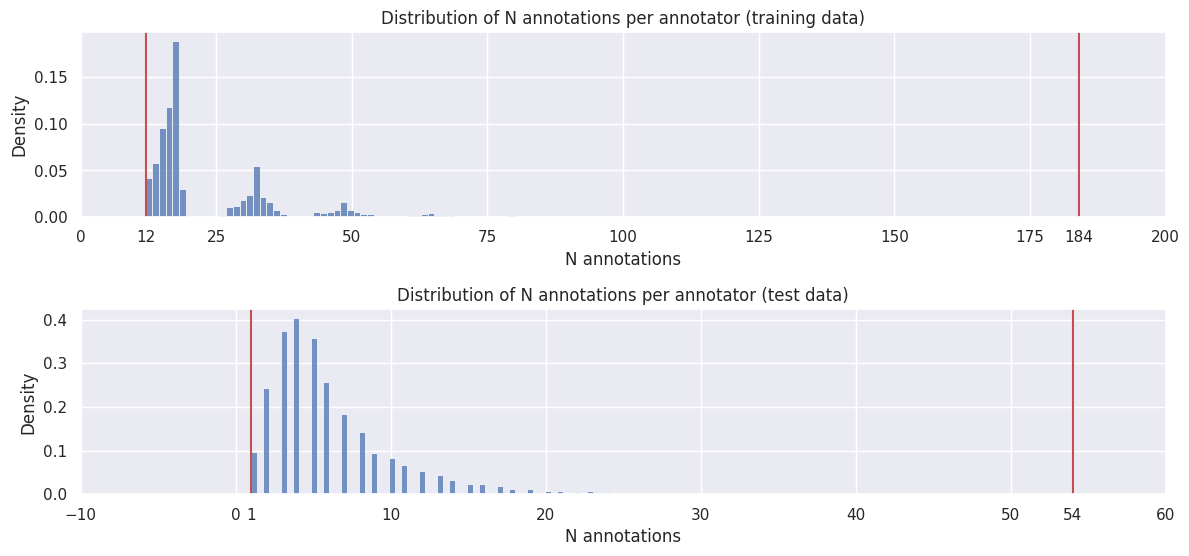

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))

plt.subplots_adjust(hspace=0.5)

# Training data.
sns.histplot(
    x=data_df_train_loaded.groupby('worker_id')['text_id'].count(),
    stat='density',
    ax=axs[0]
)

plt.sca(axs[0])

plt.axvline(
    x=data_df_train_loaded.groupby('worker_id')['text_id'].count().min(),
    color='r'
)

plt.axvline(
    x=data_df_train_loaded.groupby('worker_id')['text_id'].count().max(),
    color='r',
)

plt.xticks(
    list(plt.xticks()[0])
    + [data_df_train_loaded.groupby('worker_id')['text_id'].count().min()]
    + [data_df_train_loaded.groupby('worker_id')['text_id'].count().max()],
)
plt.title('Distribution of N annotations per annotator (training data)')
plt.xlabel('N annotations')

# Test data.
sns.histplot(
    x=data_df_test_loaded.groupby('worker_id')['text_id'].count(),
    stat='density',
    ax=axs[1]
)

plt.sca(axs[1])

plt.axvline(
    x=data_df_test_loaded.groupby('worker_id')['text_id'].count().min(),
    color='r'
)

plt.axvline(
    x=data_df_test_loaded.groupby('worker_id')['text_id'].count().max(),
    color='r',
)

plt.xticks(
    list(plt.xticks()[0])
    + [data_df_test_loaded.groupby('worker_id')['text_id'].count().min()]
    + [data_df_test_loaded.groupby('worker_id')['text_id'].count().max()],
)
plt.title('Distribution of N annotations per annotator (test data)')
plt.xlabel('N annotations')

## Annotators subsampling

**Idea:** rank the annotators by number of training (or training+test?) annotations and consider the first N in descending order. Compute the number of samples for different values of N to see the dataset size as a function of the number of annotators considered (starting from ones with the most annotations).

In [2]:
from data_utils import subsample_dataset

In [2]:
data_df_train_loaded = pd.read_csv(
    '/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/kumar_processed_with_ID_and_full_perspective_clean_train.csv'
).drop(columns=['extreme_annotator'])
data_df_test_loaded = pd.read_csv(
    '/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/kumar_processed_with_ID_and_full_perspective_clean_test.csv'
).drop(columns=['extreme_annotator'])

ANNOTATORS_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/annotators_data.csv'

annotators_data = pd.read_csv(ANNOTATORS_DATA_PATH)

In [4]:
data_df_test_loaded.shape

(106414, 5)

In [4]:
annotations_per_annotator = (
    data_df_train_loaded
    .groupby('annotator_id')['text_id']
    .count()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'text_id': 'n_annotations'})
)

annotations_per_annotator['n_annotators_cumulative_sum'] = range(1, len(annotations_per_annotator) + 1)
annotations_per_annotator['n_annotations_cumulative_sum'] = annotations_per_annotator['n_annotations'].cumsum()

# Add annotators data.
annotations_per_annotator = pd.merge(
    left=annotations_per_annotator,
    right=annotators_data[['annotator_id', 'extreme_annotator']],
    on='annotator_id',
    how='left'
)

annotations_per_annotator

,annotator_id,n_annotations,n_annotators_cumulative_sum,n_annotations_cumulative_sum,extreme_annotator
0,3663,184,1,184,False
1,907,166,2,350,False
2,2394,157,3,507,False
3,1676,156,4,663,False
4,325,153,5,816,False
...,...,...,...,...,...
17105,13923,12,17106,427910,False
17106,13924,12,17107,427922,False
17107,2546,12,17108,427934,False
17108,2547,12,17109,427946,False


<Axes: xlabel='n_annotators_cumulative_sum', ylabel='n_annotations_cumulative_sum'>

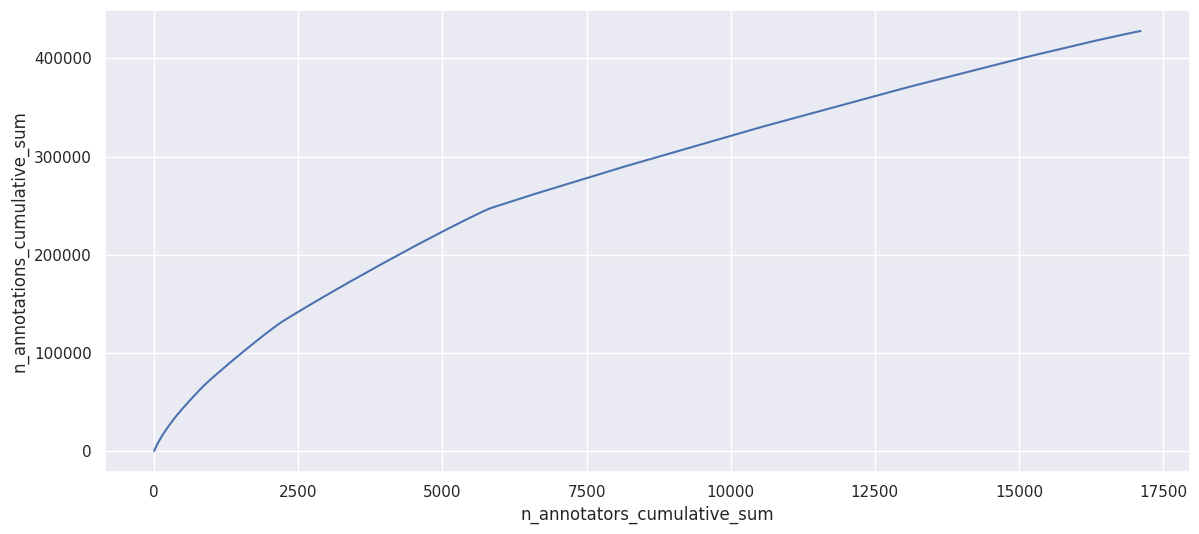

In [5]:
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=annotations_per_annotator['n_annotators_cumulative_sum'],
    y=annotations_per_annotator['n_annotations_cumulative_sum']
)

Fix the optimal number of training datapoints and get the number of annotators that must be considered.

In [6]:
optimal_n_datapoints = 150000

data_df_train_subsampled, data_df_test_subsampled = subsample_dataset(
    data_df_train_loaded,
    data_df_test_loaded,
    optimal_n_datapoints,
    ANNOTATORS_DATA_PATH
)

2025-04-16 11:33:56,385 - build_stratified_dataset - INFO - Optimal N datapoints: 150000 | Optimal N annotators: 2730
2025-04-16 11:33:56,386 - build_stratified_dataset - INFO - Subsampling the data (manually including all extreme annotators)
2025-04-16 11:33:56,415 - build_stratified_dataset - INFO - N training datapoints: 152528 | N annotators: 2883


count    2883.000000
mean       52.906001
std        20.771513
min        12.000000
25%        42.000000
50%        49.000000
75%        63.000000
max       184.000000
Name: text_id, dtype: float64

count    2883.000000
mean       12.295179
std         6.773059
min         1.000000
25%         7.000000
50%        12.000000
75%        16.000000
max        54.000000
Name: text_id, dtype: float64

Text(0.5, 0, 'N annotations')

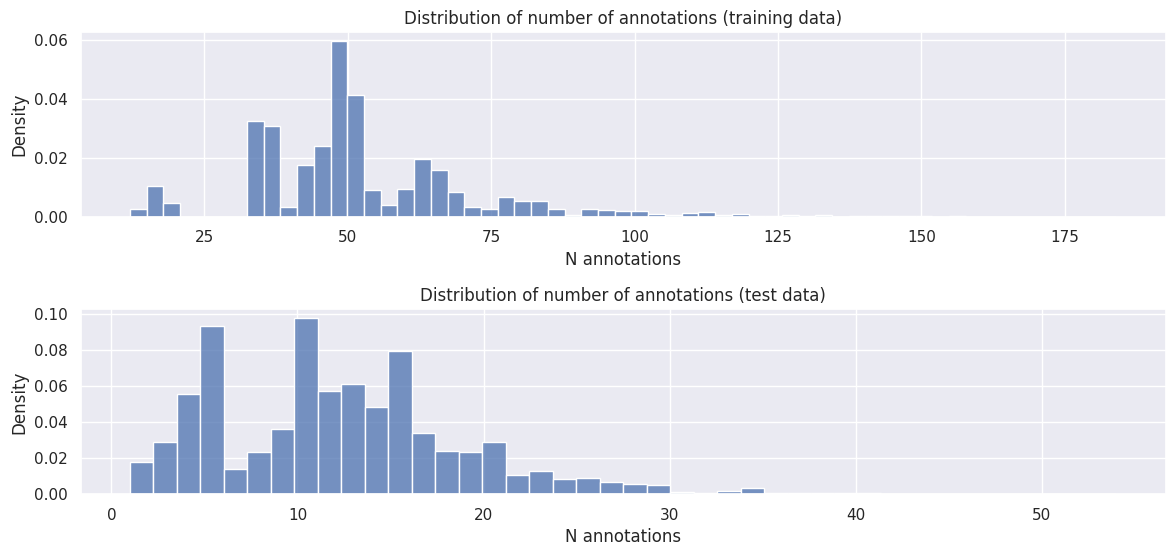

In [7]:
display(data_df_train_subsampled.groupby('annotator_id')['text_id'].count().describe())
display(data_df_test_subsampled.groupby('annotator_id')['text_id'].count().describe())

# Distribution of N annotations per annotator in the subsampled data.
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))

plt.subplots_adjust(hspace=0.5)

# Training data.
sns.histplot(
    x=data_df_train_subsampled.groupby('annotator_id')['text_id'].count(),
    stat='density',
    ax=axs[0]
)

plt.sca(axs[0])
plt.title('Distribution of number of annotations (training data)')
plt.xlabel('N annotations')

# Test data.
sns.histplot(
    x=data_df_test_subsampled.groupby('annotator_id')['text_id'].count(),
    stat='density',
    ax=axs[1]
)

plt.sca(axs[1])
plt.title('Distribution of number of annotations (test data)')
plt.xlabel('N annotations')